In [ ]:
# !pip install fastaudio
# !pip install fastai==2.5.2
# !pip install matplotlib==3.2.2
# !pip install scikit-learn==1.0.2

In [1]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
from imblearn.metrics import specificity_score

import numpy as np
import pandas as pd

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


# Preprocessing

In [2]:
CVD_loc = "../input/coughvid-wav/"
path = '../input/coughvid-wav/public_dataset/'

In [3]:
cvd_df = pd.read_csv(CVD_loc+"public_dataset/"+"metadata_compiled.csv")
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27550 non-null  object 
 1   datetime               27550 non-null  object 
 2   cough_detected         27550 non-null  float64
 3   SNR                    27550 non-null  float64
 4   latitude               16084 non-null  float64
 5   longitude              16084 non-null  float64
 6   age                    15218 non-null  float64
 7   gender                 16224 non-null  object 
 8   respiratory_condition  16224 non-null  object 
 9   fever_muscle_pain      16224 non-null  object 
 10  status                 16224 non-null  object 
 11  quality_1              820 non-null    object 
 12  cough_type_1           802 non-null    object 
 13  dyspnea_1              820 non-null    object 
 14  wheezing_1             820 non-null    object 
 15  st

In [4]:
# remove unnecessary columns

cvd_df = cvd_df.drop(columns=['datetime', 'latitude', 'longitude', 'age', 'gender', 'fever_muscle_pain',
                          'cough_type_1','dyspnea_1','wheezing_1','stridor_1','choking_1','congestion_1','nothing_1',
                          'cough_type_2','dyspnea_2','wheezing_2','stridor_2','choking_2','congestion_2','nothing_2',
                          'cough_type_3','dyspnea_3','wheezing_3','stridor_3','choking_3','congestion_3','nothing_3',
                          'cough_type_4','dyspnea_4','wheezing_4','stridor_4','choking_4','congestion_4','nothing_4'
                         ])

In [5]:
# 'cough_detected' == Probability that the recording contains cough sounds, according to their automatic detection algorithm
# also expert annotation has 'quality' of the recorded cough sound

cvd_df = cvd_df[(cvd_df['cough_detected'] > 0.8) 
                & (cvd_df['quality_1'] != 'no_cough')
                & (cvd_df['quality_2'] != 'no_cough')
                & (cvd_df['quality_3'] != 'no_cough')
                & (cvd_df['quality_4'] != 'no_cough') 
                & (cvd_df['quality_1'] != 'poor')
                & (cvd_df['quality_2'] != 'poor')
                & (cvd_df['quality_3'] != 'poor')
                & (cvd_df['quality_4'] != 'poor')
               ]

cvd_df.info()
cvd_df[:5]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14844 entries, 1 to 27549
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   14844 non-null  object 
 1   cough_detected         14844 non-null  float64
 2   SNR                    14844 non-null  float64
 3   respiratory_condition  10579 non-null  object 
 4   status                 10579 non-null  object 
 5   quality_1              638 non-null    object 
 6   diagnosis_1            638 non-null    object 
 7   severity_1             638 non-null    object 
 8   quality_2              686 non-null    object 
 9   diagnosis_2            686 non-null    object 
 10  severity_2             686 non-null    object 
 11  quality_3              747 non-null    object 
 12  diagnosis_3            747 non-null    object 
 13  severity_3             747 non-null    object 
 14  quality_4              743 non-null    object 
 15  di

uuid  cough_detected        SNR  \
1   00039425-7f3a-42aa-ac13-834aaa2b6b92          0.9609  16.151433   
3   0009eb28-d8be-4dc1-92bb-907e53bc5c7a          0.9301  20.146058   
5   001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f          0.9968  13.146502   
10  0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952          0.8937  13.477551   
11  00291cce-36a0-4a29-9e2d-c1d96ca17242          0.9883  14.603851   

   respiratory_condition   status quality_1 diagnosis_1 severity_1 quality_2  \
1                  False  healthy       NaN         NaN        NaN       NaN   
3                   True  healthy       NaN         NaN        NaN       NaN   
5                  False  healthy       NaN         NaN        NaN       NaN   
10                 False  healthy       NaN         NaN        NaN       NaN   
11                 False  healthy       NaN         NaN        NaN       NaN   

   diagnosis_2 severity_2 quality_3 diagnosis_3 severity_3 quality_4  \
1          NaN        NaN       NaN         NaN        NaN       NaN   
3          NaN        NaN       NaN         NaN        NaN       NaN   
5          NaN        NaN       NaN         NaN        NaN       NaN   
10         NaN        NaN       NaN         NaN        NaN       NaN   
11         NaN        NaN       NaN         NaN        NaN       NaN   

   diagnosis_4 severity_4  
1          NaN        NaN  
3          NaN        NaN  
5          NaN        NaN  
10         NaN        NaN  
11         NaN        NaN

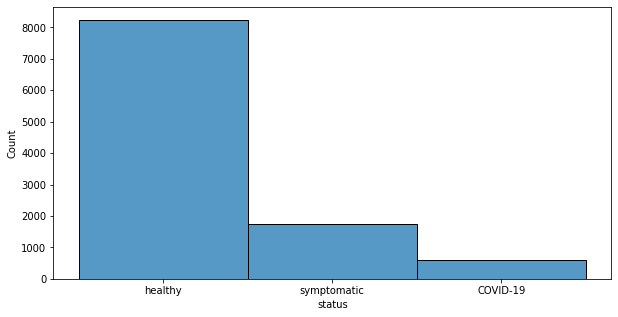

In [6]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.histplot(cvd_df['status'])

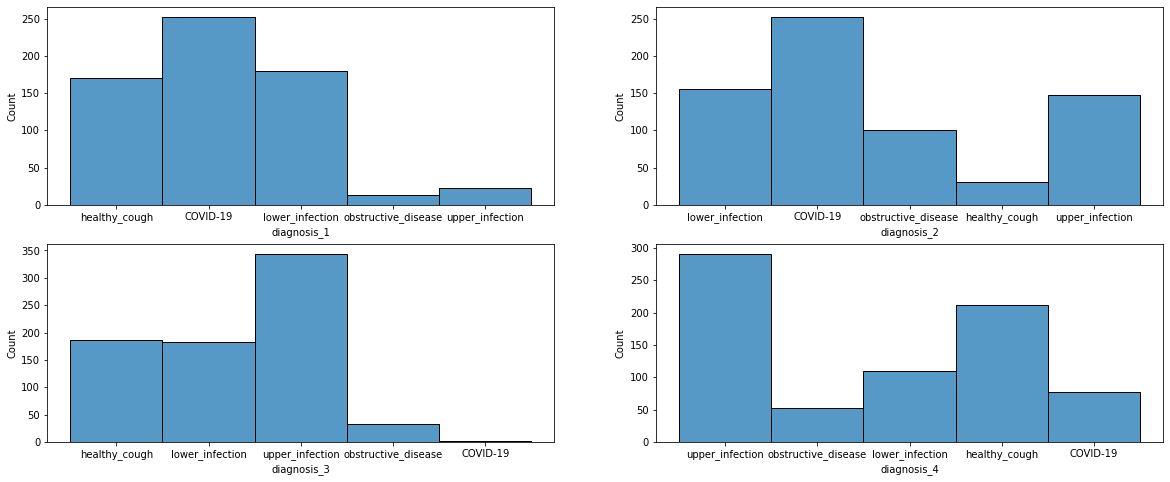

In [7]:
plt.figure(figsize=(20,8))

plt.subplot(2, 2, 1)
sns.histplot(cvd_df['diagnosis_1'])
plt.subplot(2, 2, 2)
sns.histplot(cvd_df['diagnosis_2'])
plt.subplot(2, 2, 3)
sns.histplot(cvd_df['diagnosis_3'])
plt.subplot(2, 2, 4)
sns.histplot(cvd_df['diagnosis_4'])

In [8]:
# The patient's "status" is 'COVID-19' 

cvd_covid = cvd_df[(cvd_df.status == 'COVID-19')]

#cvd_covid.to_csv('cvd_covid.csv')

print('SAMPLES: -->',len(cvd_covid))
cvd_covid.info()
cvd_covid[:3]

SAMPLES: --> 596
<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 140 to 27503
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   596 non-null    object 
 1   cough_detected         596 non-null    float64
 2   SNR                    596 non-null    float64
 3   respiratory_condition  596 non-null    object 
 4   status                 596 non-null    object 
 5   quality_1              145 non-null    object 
 6   diagnosis_1            145 non-null    object 
 7   severity_1             145 non-null    object 
 8   quality_2              154 non-null    object 
 9   diagnosis_2            154 non-null    object 
 10  severity_2             154 non-null    object 
 11  quality_3              176 non-null    object 
 12  diagnosis_3            176 non-null    object 
 13  severity_3             176 non-null    object 
 14  quality_4              187 non-null  

uuid  cough_detected        SNR  \
140  015576c8-2b03-4dcb-b251-78a984fe86fe             1.0  12.265701   
155  0177b817-0ba3-498a-bc05-48bc66cc91b8             1.0  20.441756   
158  01820f7c-b953-4faf-aa13-978cfda6b08e             1.0   9.280698   

    respiratory_condition    status quality_1 diagnosis_1 severity_1  \
140                 False  COVID-19       NaN         NaN        NaN   
155                 False  COVID-19       NaN         NaN        NaN   
158                 False  COVID-19       NaN         NaN        NaN   

    quality_2          diagnosis_2 severity_2 quality_3 diagnosis_3  \
140       NaN                  NaN        NaN       NaN         NaN   
155        ok  obstructive_disease       mild       NaN         NaN   
158       NaN                  NaN        NaN       NaN         NaN   

    severity_3 quality_4          diagnosis_4 severity_4  
140        NaN      good  obstructive_disease       mild  
155        NaN       NaN                  NaN        NaN  
158        NaN      good  obstructive_disease     severe

In [9]:
# The patient "status" is 'healthy'
# to balance the ratio with covid positive samples, added some extra condition like ->
# patinet has 'no' "respiratory_condition" AND
# expert "diagnosis" is not 'upper_infection, lower_infection, obstructive_disease, COVID-19 and
# selected 1788 (3x times covid positive samples) after sorting the dataframe by 'cough_detected', 'SNR' values
 
cvd_healthy = cvd_df[(cvd_df['status'] == 'healthy') 
                     &(cvd_df['respiratory_condition'] == False) 
                     &(cvd_df['diagnosis_1'] != 'upper_infection')
                     &(cvd_df['diagnosis_2'] != 'upper_infection')
                     &(cvd_df['diagnosis_3'] != 'upper_infection')
                     &(cvd_df['diagnosis_4'] != 'upper_infection') 
                     &(cvd_df['diagnosis_1'] != 'lower_infection')
                     &(cvd_df['diagnosis_2'] != 'lower_infection')
                     &(cvd_df['diagnosis_3'] != 'lower_infection')
                     &(cvd_df['diagnosis_4'] != 'lower_infection')
                     &(cvd_df['diagnosis_1'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_2'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_3'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_4'] != 'obstructive_disease')
                     &(cvd_df['diagnosis_1'] != 'COVID-19')
                     &(cvd_df['diagnosis_2'] != 'COVID-19')
                     &(cvd_df['diagnosis_3'] != 'COVID-19')
                     &(cvd_df['diagnosis_4'] != 'COVID-19')
                    ]

cvd_healthy = cvd_healthy.sort_values(by=['cough_detected', 'SNR'], ascending=False)
cvd_healthy = cvd_healthy[:(596*3)]

#cvd_healthy.to_csv('cvd_healthy.csv')

print('SAMPLES: -->',len(cvd_healthy))
cvd_healthy.info()
cvd_healthy[:3]

SAMPLES: --> 1788
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788 entries, 6591 to 13242
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   1788 non-null   object 
 1   cough_detected         1788 non-null   float64
 2   SNR                    1788 non-null   float64
 3   respiratory_condition  1788 non-null   object 
 4   status                 1788 non-null   object 
 5   quality_1              38 non-null     object 
 6   diagnosis_1            38 non-null     object 
 7   severity_1             38 non-null     object 
 8   quality_2              9 non-null      object 
 9   diagnosis_2            9 non-null      object 
 10  severity_2             9 non-null      object 
 11  quality_3              30 non-null     object 
 12  diagnosis_3            30 non-null     object 
 13  severity_3             30 non-null     object 
 14  quality_4              70 non-null

uuid  cough_detected        SNR  \
6591   3d8a71a7-e94f-425c-8b92-09aceddcd063             1.0  78.847184   
2434   16af8331-f890-4f2e-bf49-2b42985d379e             1.0  76.186442   
10806  647da923-9dfe-4527-9ec6-473b8fb791ca             1.0  75.226517   

      respiratory_condition   status quality_1 diagnosis_1 severity_1  \
6591                  False  healthy       NaN         NaN        NaN   
2434                  False  healthy       NaN         NaN        NaN   
10806                 False  healthy       NaN         NaN        NaN   

      quality_2 diagnosis_2 severity_2 quality_3 diagnosis_3 severity_3  \
6591        NaN         NaN        NaN       NaN         NaN        NaN   
2434        NaN         NaN        NaN       NaN         NaN        NaN   
10806       NaN         NaN        NaN       NaN         NaN        NaN   

      quality_4    diagnosis_4   severity_4  
6591       good  healthy_cough  pseudocough  
2434       good  healthy_cough  pseudocough  
10806      good  healthy_cough  pseudocough

In [10]:
# loads all file paths from location

cvd_files = get_files(
  path = path,
  extensions = '.wav',
  recurse = True
)

print(len(cvd_files))
cvd_files[:3]

27550


(#3) [Path('../input/coughvid-wav/public_dataset/7444620d-bf48-451b-8e48-7c632d8f5a1c.wav'),Path('../input/coughvid-wav/public_dataset/4344101d-3fc1-47fd-be0d-c8d4b4caa940.wav'),Path('../input/coughvid-wav/public_dataset/bb0c6cd9-6465-47ad-be51-7189156d5f2e.wav')]

In [11]:
# method to get file paths

def getit(id):
    for i in cvd_files:
        folders = str(i).split("/")[-1].split('.wav')
        #print(folders)
        if folders[0] == id:
            #print(str(i).split('public_dataset/')[-1])
            return str(i).split('public_dataset/')[-1]

In [12]:
file_names = []
labels = []

for i in cvd_covid.uuid.values:
    file_names.append(getit(i))
    labels.append('COVID POSITIVE')

for i in cvd_healthy.uuid.values:
    file_names.append(getit(i))
    labels.append('COVID NEGATIVE')
    
print(file_names[:3])
print(labels[:3])

Counter(labels)

['015576c8-2b03-4dcb-b251-78a984fe86fe.wav', '0177b817-0ba3-498a-bc05-48bc66cc91b8.wav', '01820f7c-b953-4faf-aa13-978cfda6b08e.wav']
['COVID POSITIVE', 'COVID POSITIVE', 'COVID POSITIVE']


Counter({'COVID POSITIVE': 596, 'COVID NEGATIVE': 1788})

In [13]:
# dataframe for dataloader

df = pd.DataFrame({'filename' : file_names, 'category': labels})
three_df = df.copy()
three_df

filename        category
0     015576c8-2b03-4dcb-b251-78a984fe86fe.wav  COVID POSITIVE
1     0177b817-0ba3-498a-bc05-48bc66cc91b8.wav  COVID POSITIVE
2     01820f7c-b953-4faf-aa13-978cfda6b08e.wav  COVID POSITIVE
3     01bf156f-a8ff-48f6-9335-8a1f5bb4c1b7.wav  COVID POSITIVE
4     02aa80ef-a83b-477f-b01d-575651364b22.wav  COVID POSITIVE
...                                        ...             ...
2379  fbcd0f5a-5778-43a2-ac82-52e2077f5e9b.wav  COVID NEGATIVE
2380  81a9a512-b01f-4115-bf8c-f60728fdf0dc.wav  COVID NEGATIVE
2381  43e48031-e0db-441d-9b18-dc882cc99867.wav  COVID NEGATIVE
2382  f1b4540e-c434-42dd-bce7-46ba54240c39.wav  COVID NEGATIVE
2383  7ac68b6e-ea41-4eb0-9eda-7b09169dce8f.wav  COVID NEGATIVE

[2384 rows x 2 columns]

In [14]:
# # check audio files samplerate

# sr_list = []

# for i in three_df.filename.values:
#     sr_list.append(librosa.get_samplerate(path+i))
    
# sr_list = np.array(sr_list)

# values, counts = np.unique(sr_list, return_counts=True)
# print(values, counts)

# #output [48000] [2384]

# # check duration of each files

# dur_list = []
# failed_list = []
# for i in three_df.filename.values:
#     try:
#         y, sr = librosa.load(path+i)
#         dur_list.append(librosa.get_duration(y=y, sr=sr))
#     except:
#         failed_list.append(i)
#         pass
    
# dur_list = np.array(dur_list)

# print(np.mean(dur_list))
# print(np.average(dur_list))

# #output
# #8.434474425116804
# #8.434474425116804

# # files failed to load
# print(failed_list[:3])
# len(failed_list)

# # remove corrupted files
# for i in failed_list:
#     print(i)
#     three_df.drop(three_df[three_df.filename == i].index, inplace=True)
# three_df

COVID NEGATIVE    1788
COVID POSITIVE     596
Name: category, dtype: int64

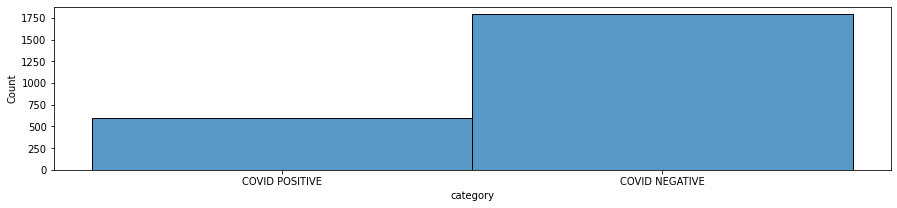

In [15]:
# check class distribution
plt.figure(figsize=(15,3))
sns.histplot(three_df['category'])

three_df['category'].value_counts()

In [16]:
three_df.to_csv('coughvid_df_2class.csv', index=False) 

# Mel-Spectrogram and Augmentation

In [17]:
# resize audio to a uniform length and create mel-spectrogram from audio

cfg = AudioConfig.BasicMelSpectrogram(sample_rate=22050, n_fft=1024, hop_length=512, f_min=0.0, f_max=4000,
                                      n_mels=64, normalized=False, norm=None, mel=True, to_db=True)

crop8s = ResizeSignal(duration=8000)
a2s = AudioToSpec.from_cfg(cfg)
SGR = SGRoll(max_shift_pct=0.5, direction=0)
MT = MaskTime(size=5)
MF =  MaskFreq(size=5)

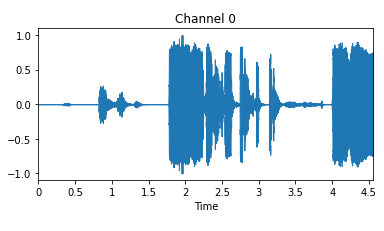

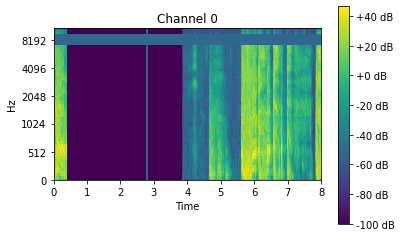

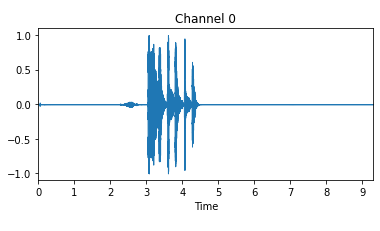

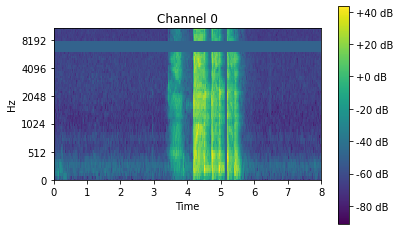

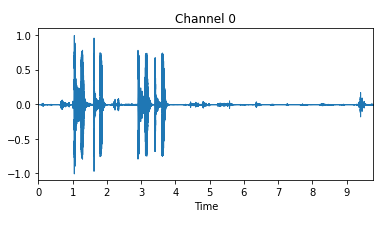

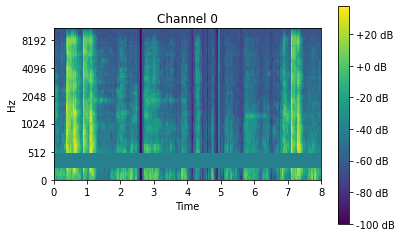

In [18]:
# check transformations
pipe = Pipeline([AudioTensor.create, crop8s, a2s, SGR, MT, MF])

for fn in three_df.filename.values[42:45]:
      audio = AudioTensor.create(path+fn)
      audio.show()
      pipe(path+fn).show()

## Dataloader

In [19]:
three_df, three_df_test = train_test_split(three_df, test_size=0.10, random_state=43, stratify=three_df.category.values)

In [20]:
print(three_df.category.value_counts())
print(three_df_test.category.value_counts())

COVID NEGATIVE    1609
COVID POSITIVE     536
Name: category, dtype: int64
COVID NEGATIVE    179
COVID POSITIVE     60
Name: category, dtype: int64


Setting-up type transforms pipelines
791   6f26632b-55f2-499f-8508-9f769be196e4.wav  COVID NEGATIVE
1343  480a4a2f-ff2f-4bbf-919f-217147536860.wav  COVID NEGATIVE
967   ec0be4e6-5434-482e-8685-ac35bdc553d6.wav  COVID NEGATIVE
1458  0f4b619a-862b-49aa-b751-ea93cde09f98.wav  COVID NEGATIVE
734   2532b7ae-20da-4dde-ab4e-46ffe1fdbe77.wav  COVID NEGATIVE
...                                        ...             ...
260   7117304a-e59b-42c9-bea9-3c6f17b0d30e.wav  COVID POSITIVE
1615  be329b01-ffe4-4349-9f64-bf20e4496ae2.wav  COVID NEGATIVE
1990  d8b923f9-8ca0-41c3-9ebf-7dcd8ab24e9c.wav  COVID NEGATIVE
338   9736398b-2034-43a8-88e1-affa632772c9.wav  COVID POSITIVE
530   e586aff4-968f-4299-b092-3e9a59472689.wav  COVID POSITIVE

[2145 rows x 2 columns]
Found 2145 items
2 datasets of sizes 1930,215
Setting up Pipeline: ColReader -- {'cols': 'filename', 'pref': '../input/coughvid-wav/public_dataset/', 'suff': '', 'label_delim': None} -> partial
Setting up Pipeline: ColReader -- {'cols': 'categor

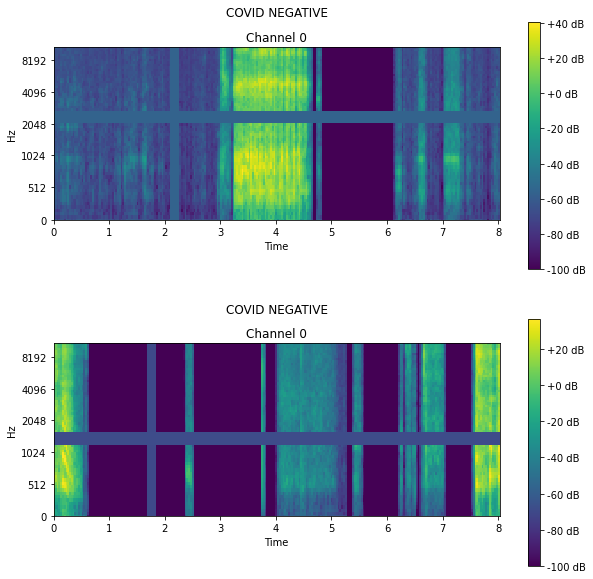

In [21]:
item_tfms = [crop8s, a2s, SGR, MT, MF]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref= path),
                 splitter = TrainTestSplitter(test_size=0.10, random_state=43, 
                                              stratify=three_df.category.values),
                 item_tfms = item_tfms,
                 get_y = ColReader("category"))


auds.summary(three_df, show_batch=True, figsize=(10, 10))

## Check data distribution

In [22]:
dls_noweight = auds.dataloaders(three_df, bs=32)

for i in range(10):
    x,y = dls_noweight.one_batch()
    print(np.unique(y.cpu(), return_counts=True))

print(dls_noweight.train.items.category.value_counts())
print(dls_noweight.valid.items.category.value_counts())

(array([0, 1]), array([24,  8]))
(array([0, 1]), array([24,  8]))
(array([0, 1]), array([22, 10]))
(array([0, 1]), array([24,  8]))
(array([0, 1]), array([23,  9]))
(array([0, 1]), array([27,  5]))
(array([0, 1]), array([23,  9]))
(array([0, 1]), array([22, 10]))
(array([0, 1]), array([27,  5]))
(array([0, 1]), array([23,  9]))
COVID NEGATIVE    1448
COVID POSITIVE     482
Name: category, dtype: int64
COVID NEGATIVE    161
COVID POSITIVE     54
Name: category, dtype: int64


## Weighted Dataloader

In [23]:
dsets = auds.datasets(three_df)

count = Counter(three_df.category.values)
wgts = [1/count[dsets.vocab[label]] for cat, label in dsets.train]
wgts[:10]
np.unique(np.array(wgts), return_counts=True)

(array([0.0006215 , 0.00186567]), array([1448,  482]))

(array([0, 1]), array([16, 16]))
(array([0, 1]), array([11, 21]))
(array([0, 1]), array([17, 15]))
(array([0, 1]), array([12, 20]))
(array([0, 1]), array([16, 16]))
(array([0, 1]), array([15, 17]))
(array([0, 1]), array([17, 15]))
(array([0, 1]), array([16, 16]))
(array([0, 1]), array([14, 18]))
(array([0, 1]), array([13, 19]))


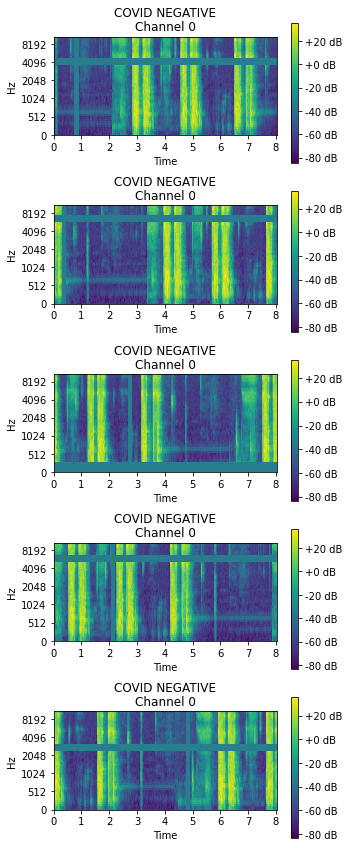

In [24]:
dls = auds.dataloaders(three_df, bs=32, dl_type=WeightedDL, wgts=wgts)

for i in range(10):
    x,y = dls.one_batch()
    print(np.unique(y.cpu(), return_counts=True))

dls.train.show_batch(max_n=5, nrows=5, unique=True, figsize=(5, 15))

In [25]:
test_dl = dls.test_dl(three_df_test, with_labels=True)

In [26]:
print(dls.train.items.category.value_counts())
print(dls.valid.items.category.value_counts())
print(test_dl.items.category.value_counts())

COVID NEGATIVE    1448
COVID POSITIVE     482
Name: category, dtype: int64
COVID NEGATIVE    161
COVID POSITIVE     54
Name: category, dtype: int64
COVID NEGATIVE    179
COVID POSITIVE     60
Name: category, dtype: int64


# Models: Fine-tuning

### ResNet-18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5813953280448914.


Better model found at epoch 0 with accuracy value: 0.5302325487136841.
Better model found at epoch 1 with accuracy value: 0.5581395626068115.
Better model found at epoch 2 with accuracy value: 0.6000000238418579.
Better model found at epoch 6 with accuracy value: 0.6093023419380188.
Better model found at epoch 9 with accuracy value: 0.6232557892799377.
Better model found at epoch 10 with accuracy value: 0.6279069781303406.
Better model found at epoch 12 with accuracy value: 0.669767439365387.
No improvement since epoch 12: early stopping


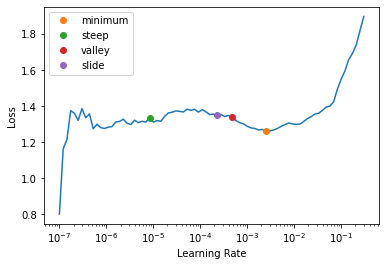

In [27]:
# resnet 18 model
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

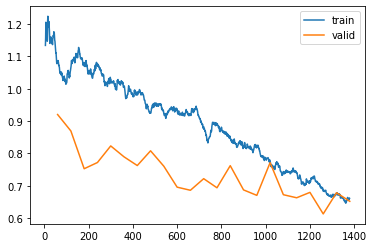

In [28]:
learn.recorder.plot_loss()

0.5983263598326359 0.6269087523277469 0.5490566037735849 0.5767225325884544 0.5767225325884544 0.5592805755395683
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.5983263598326359	0.6269087523277469	0.5490566037735849	0.5767225325884544	0.5767225325884544	0.5592805755395683
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       179
           1       0.32      0.53      0.40        60

    accuracy                           0.60       239
   macro avg       0.56      0.58      0.55       239
weighted avg       0.68      0.60      0.62       239



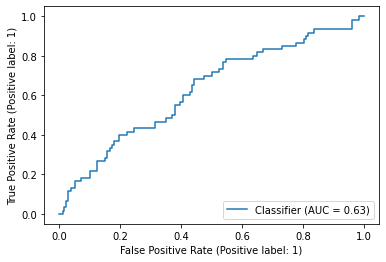

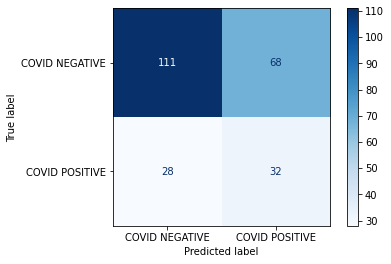

In [29]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-34

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5534883737564087.


Better model found at epoch 0 with accuracy value: 0.6139534711837769.
Better model found at epoch 2 with accuracy value: 0.6418604850769043.
Better model found at epoch 6 with accuracy value: 0.6511628031730652.
Better model found at epoch 8 with accuracy value: 0.6604651212692261.
Better model found at epoch 13 with accuracy value: 0.669767439365387.
Better model found at epoch 16 with accuracy value: 0.7023255825042725.
Better model found at epoch 22 with accuracy value: 0.7162790894508362.
Better model found at epoch 30 with accuracy value: 0.7209302186965942.
Better model found at epoch 35 with accuracy value: 0.7255814075469971.
Better model found at epoch 37 with accuracy value: 0.739534854888916.
No improvement since epoch 37: early stopping


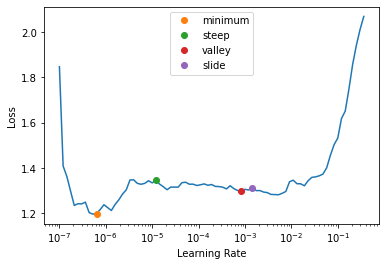

In [30]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

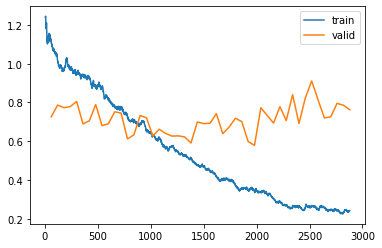

In [31]:
learn.recorder.plot_loss()

0.6820083682008368 0.6728119180633148 0.5945535714285715 0.5993482309124767 0.5993482309124767 0.5917612659098728
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6820083682008368	0.6728119180633148	0.5945535714285715	0.5993482309124767	0.5993482309124767	0.5917612659098728
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       179
           1       0.38      0.43      0.41        60

    accuracy                           0.68       239
   macro avg       0.59      0.60      0.59       239
weighted avg       0.70      0.68      0.69       239



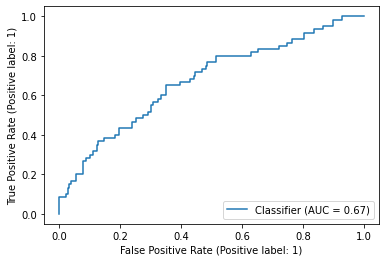

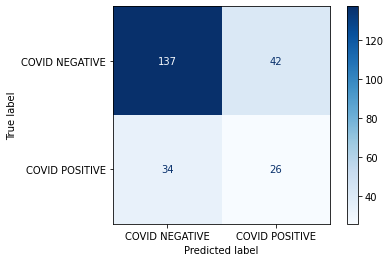

In [32]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.5674418807029724.


Better model found at epoch 0 with accuracy value: 0.6093023419380188.
Better model found at epoch 2 with accuracy value: 0.6279069781303406.
Better model found at epoch 3 with accuracy value: 0.6558139324188232.
Better model found at epoch 4 with accuracy value: 0.6651162505149841.
Better model found at epoch 13 with accuracy value: 0.6790697574615479.
Better model found at epoch 17 with accuracy value: 0.6883720755577087.
Better model found at epoch 21 with accuracy value: 0.7116279006004333.
Better model found at epoch 26 with accuracy value: 0.7302325367927551.
No improvement since epoch 26: early stopping


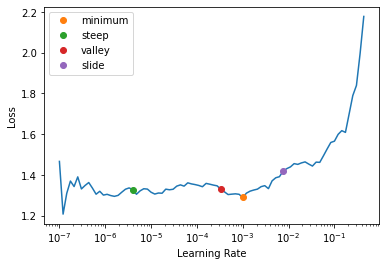

In [33]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

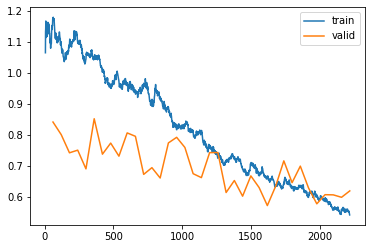

In [34]:
learn.recorder.plot_loss()

0.6527196652719666 0.654562383612663 0.5676800697395663 0.5742551210428305 0.5742551210428305 0.5658111899653409
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6527196652719666	0.654562383612663	0.5676800697395663	0.5742551210428305	0.5742551210428305	0.5658111899653409
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       179
           1       0.34      0.42      0.38        60

    accuracy                           0.65       239
   macro avg       0.57      0.57      0.57       239
weighted avg       0.68      0.65      0.66       239



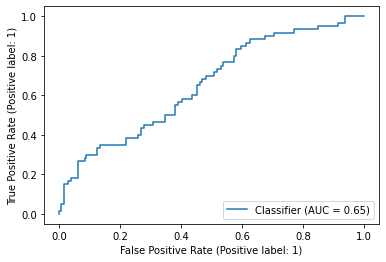

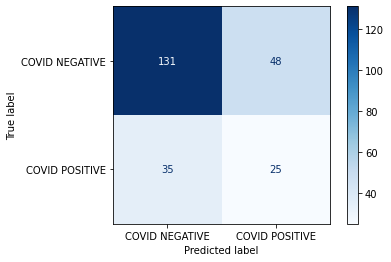

In [35]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-101

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6465116143226624.


Better model found at epoch 0 with accuracy value: 0.5860465168952942.
Better model found at epoch 1 with accuracy value: 0.5953488349914551.
Better model found at epoch 2 with accuracy value: 0.6232557892799377.
Better model found at epoch 4 with accuracy value: 0.6558139324188232.
Better model found at epoch 7 with accuracy value: 0.6837209463119507.
Better model found at epoch 13 with accuracy value: 0.6883720755577087.
No improvement since epoch 13: early stopping


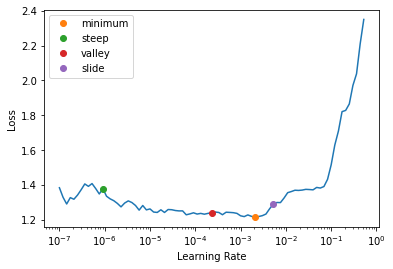

In [36]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

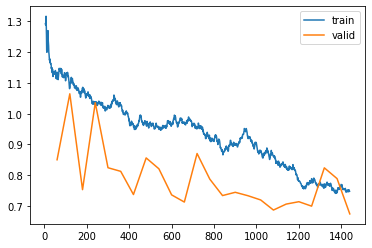

In [37]:
learn.recorder.plot_loss()

0.6527196652719666 0.6 0.575379412205407 0.5853351955307262 0.5853351955307262 0.5734728234728235
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6527196652719666	0.6	0.575379412205407	0.5853351955307262	0.5853351955307262	0.5734728234728235
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       179
           1       0.35      0.45      0.39        60

    accuracy                           0.65       239
   macro avg       0.57      0.59      0.58       239
weighted avg       0.68      0.65      0.67       239



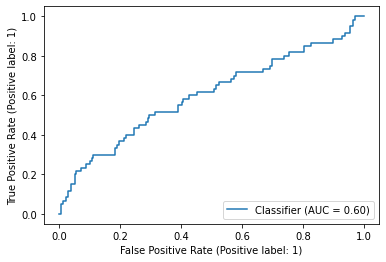

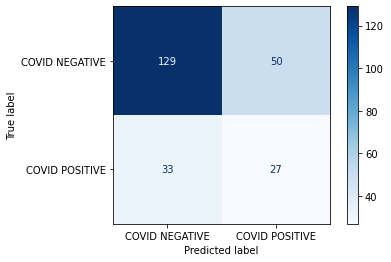

In [38]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg16_bn

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.604651153087616.


Better model found at epoch 0 with accuracy value: 0.6232557892799377.
Better model found at epoch 1 with accuracy value: 0.6558139324188232.
Better model found at epoch 2 with accuracy value: 0.669767439365387.
Better model found at epoch 3 with accuracy value: 0.6790697574615479.
Better model found at epoch 4 with accuracy value: 0.6883720755577087.
Better model found at epoch 5 with accuracy value: 0.7162790894508362.
Better model found at epoch 8 with accuracy value: 0.7209302186965942.
Better model found at epoch 12 with accuracy value: 0.7627906799316406.
Better model found at epoch 20 with accuracy value: 0.7674418687820435.
Better model found at epoch 26 with accuracy value: 0.7720929980278015.
Better model found at epoch 28 with accuracy value: 0.7906976938247681.
No improvement since epoch 28: early stopping


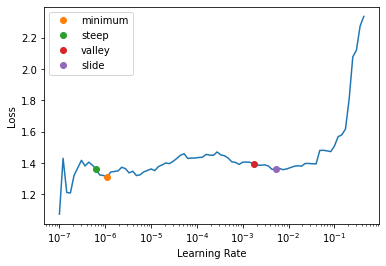

In [39]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

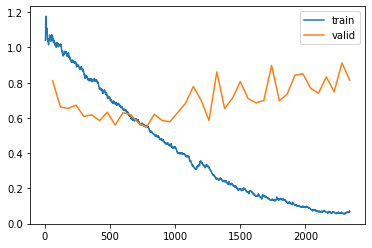

In [40]:
learn.recorder.plot_loss()

0.7238493723849372 0.6470204841713222 0.5887046307884856 0.5829608938547486 0.5829608938547486 0.6076867295141407
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7238493723849372	0.6470204841713222	0.5887046307884856	0.5829608938547486	0.5829608938547486	0.6076867295141407
              precision    recall  f1-score   support

           0       0.79      0.87      0.82       179
           1       0.43      0.30      0.35        60

    accuracy                           0.72       239
   macro avg       0.61      0.58      0.59       239
weighted avg       0.70      0.72      0.71       239



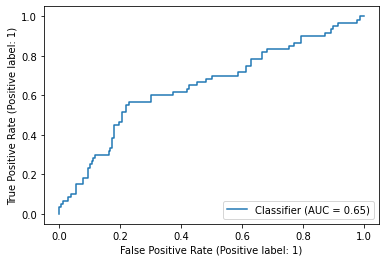

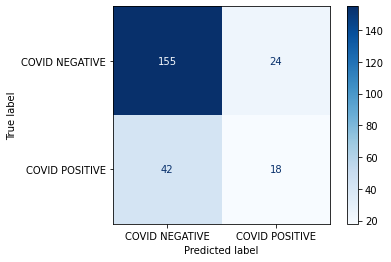

In [41]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg19_bn

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.4883720874786377.


Better model found at epoch 0 with accuracy value: 0.5953488349914551.
Better model found at epoch 2 with accuracy value: 0.6558139324188232.
Better model found at epoch 3 with accuracy value: 0.6744186282157898.
Better model found at epoch 12 with accuracy value: 0.6930232644081116.
Better model found at epoch 14 with accuracy value: 0.7209302186965942.
No improvement since epoch 14: early stopping


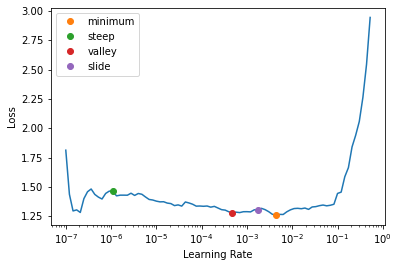

In [42]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

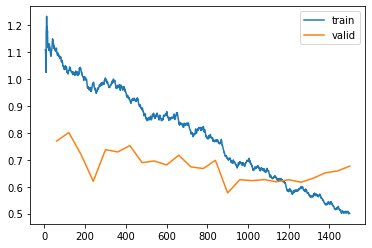

In [43]:
learn.recorder.plot_loss()

0.6569037656903766 0.6835195530726257 0.6044962867290927 0.6324487895716946 0.6324487895716946 0.6051833776989057
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6569037656903766	0.6835195530726257	0.6044962867290927	0.6324487895716946	0.6324487895716946	0.6051833776989057
              precision    recall  f1-score   support

           0       0.83      0.68      0.75       179
           1       0.38      0.58      0.46        60

    accuracy                           0.66       239
   macro avg       0.61      0.63      0.60       239
weighted avg       0.72      0.66      0.68       239



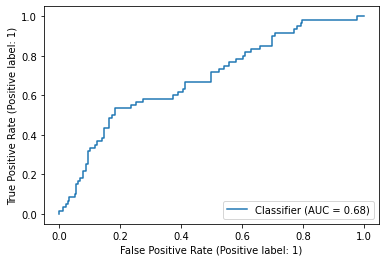

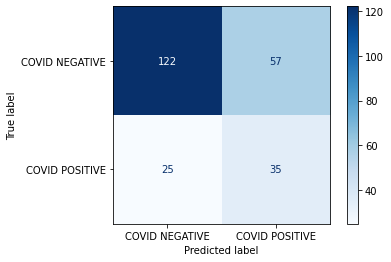

In [44]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6232557892799377.


Better model found at epoch 0 with accuracy value: 0.5674418807029724.
Better model found at epoch 1 with accuracy value: 0.6744186282157898.
Better model found at epoch 7 with accuracy value: 0.6790697574615479.
Better model found at epoch 10 with accuracy value: 0.6883720755577087.
Better model found at epoch 11 with accuracy value: 0.6930232644081116.
Better model found at epoch 17 with accuracy value: 0.7116279006004333.
Better model found at epoch 19 with accuracy value: 0.7162790894508362.
No improvement since epoch 19: early stopping


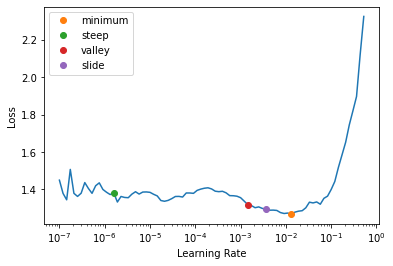

In [45]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

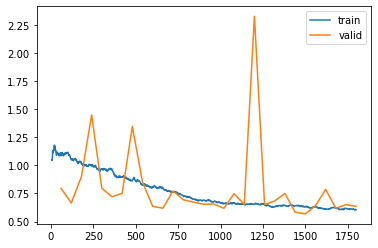

In [46]:
learn.recorder.plot_loss()

0.6778242677824268 0.6307262569832403 0.5951558615834744 0.6020949720670391 0.6020949720670391 0.5919265593561368
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6778242677824268	0.6307262569832403	0.5951558615834744	0.6020949720670391	0.6020949720670391	0.5919265593561368
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       179
           1       0.38      0.45      0.41        60

    accuracy                           0.68       239
   macro avg       0.59      0.60      0.60       239
weighted avg       0.70      0.68      0.69       239



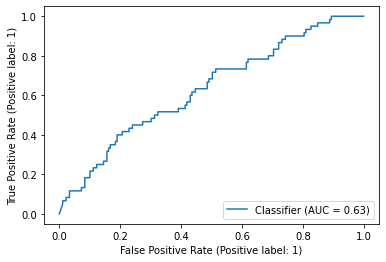

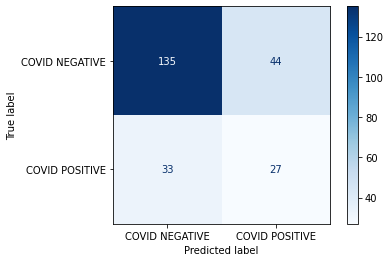

In [47]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### squeezenet1_0

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6093023419380188.


Better model found at epoch 0 with accuracy value: 0.5627906918525696.
Better model found at epoch 1 with accuracy value: 0.5767441987991333.
Better model found at epoch 2 with accuracy value: 0.6232557892799377.
Better model found at epoch 4 with accuracy value: 0.6558139324188232.
Better model found at epoch 7 with accuracy value: 0.6790697574615479.
Better model found at epoch 15 with accuracy value: 0.6930232644081116.
Better model found at epoch 16 with accuracy value: 0.7162790894508362.
No improvement since epoch 16: early stopping


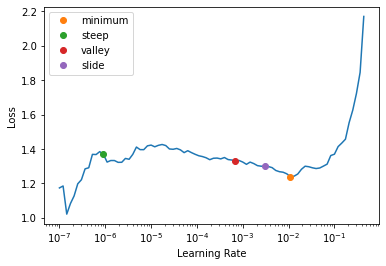

In [48]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

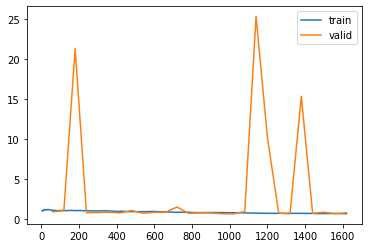

In [49]:
learn.recorder.plot_loss()

0.6527196652719666 0.6145251396648045 0.5716013389482777 0.5797951582867784 0.5797951582867784 0.5696747967479675
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6527196652719666	0.6145251396648045	0.5716013389482777	0.5797951582867784	0.5797951582867784	0.5696747967479675
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       179
           1       0.35      0.43      0.39        60

    accuracy                           0.65       239
   macro avg       0.57      0.58      0.57       239
weighted avg       0.68      0.65      0.66       239



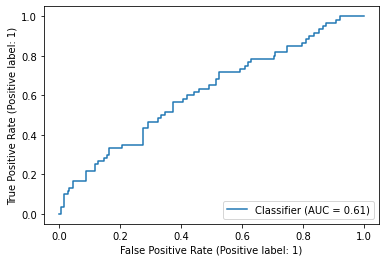

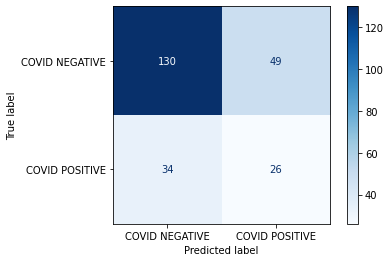

In [50]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### densenet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6976743936538696.


Better model found at epoch 0 with accuracy value: 0.6418604850769043.
Better model found at epoch 2 with accuracy value: 0.6511628031730652.
Better model found at epoch 6 with accuracy value: 0.6837209463119507.
Better model found at epoch 15 with accuracy value: 0.7116279006004333.
No improvement since epoch 15: early stopping


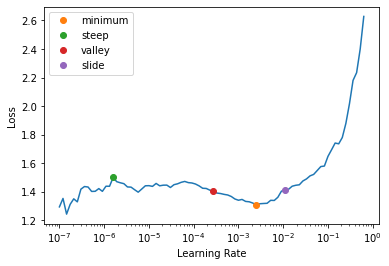

In [51]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

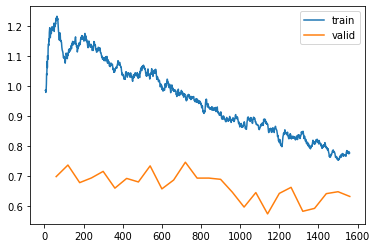

In [52]:
learn.recorder.plot_loss()

0.6736401673640168 0.653538175046555 0.6124001996007984 0.6325418994413408 0.6325418994413408 0.6093317972350231
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6736401673640168	0.653538175046555	0.6124001996007984	0.6325418994413408	0.6325418994413408	0.6093317972350231
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       179
           1       0.39      0.55      0.46        60

    accuracy                           0.67       239
   macro avg       0.61      0.63      0.61       239
weighted avg       0.72      0.67      0.69       239



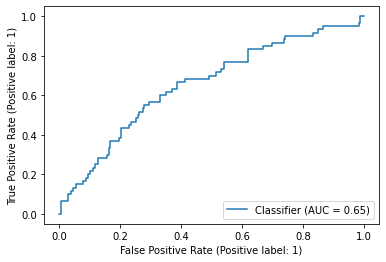

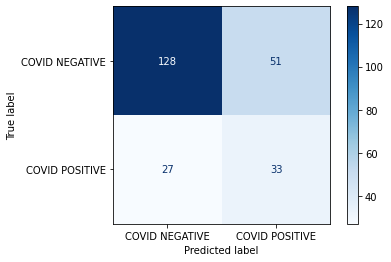

In [53]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### xresnet50

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6093023419380188.


Better model found at epoch 0 with accuracy value: 0.6883720755577087.
Better model found at epoch 4 with accuracy value: 0.7023255825042725.
Better model found at epoch 10 with accuracy value: 0.734883725643158.
Better model found at epoch 12 with accuracy value: 0.8139534592628479.
No improvement since epoch 12: early stopping


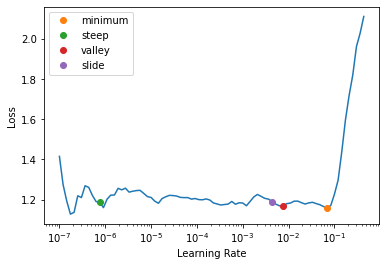

In [54]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fine_tune(50, lrs.valley)

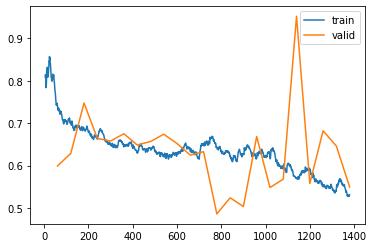

In [55]:
learn.recorder.plot_loss()

0.7531380753138075 0.7167597765363127 0.5927038502642904 0.5858938547486033 0.5858938547486033 0.6514778325123153
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.7531380753138075	0.7167597765363127	0.5927038502642904	0.5858938547486033	0.5858938547486033	0.6514778325123153
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       179
           1       0.52      0.25      0.34        60

    accuracy                           0.75       239
   macro avg       0.65      0.59      0.59       239
weighted avg       0.72      0.75      0.72       239



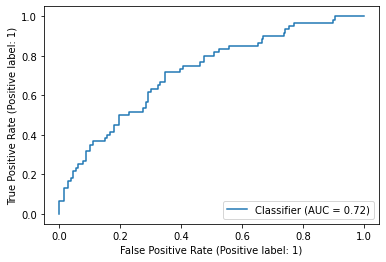

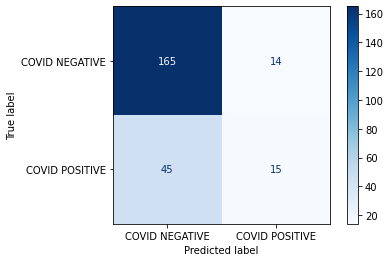

In [56]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

# Models: 1cycle policy

### ResNet-18

Better model found at epoch 0 with accuracy value: 0.5674418807029724.
Better model found at epoch 3 with accuracy value: 0.6279069781303406.
Better model found at epoch 7 with accuracy value: 0.6465116143226624.
Better model found at epoch 12 with accuracy value: 0.6651162505149841.
Better model found at epoch 20 with accuracy value: 0.6883720755577087.
Better model found at epoch 21 with accuracy value: 0.7209302186965942.
Better model found at epoch 27 with accuracy value: 0.7534883618354797.
No improvement since epoch 27: early stopping


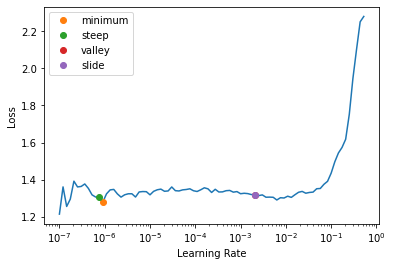

In [57]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

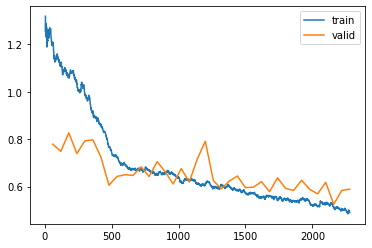

In [58]:
learn.recorder.plot_loss()

0.6778242677824268 0.7011173184357543 0.5912352013504809 0.5965549348230912 0.5965549348230912 0.5884057971014494
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6778242677824268	0.7011173184357543	0.5912352013504809	0.5965549348230912	0.5965549348230912	0.5884057971014494
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       179
           1       0.38      0.43      0.40        60

    accuracy                           0.68       239
   macro avg       0.59      0.60      0.59       239
weighted avg       0.69      0.68      0.68       239



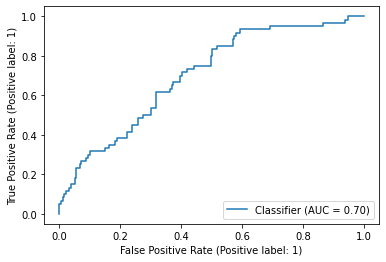

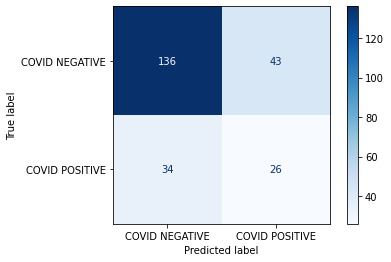

In [59]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-34

Better model found at epoch 0 with accuracy value: 0.5441860556602478.
Better model found at epoch 2 with accuracy value: 0.6139534711837769.
Better model found at epoch 9 with accuracy value: 0.6279069781303406.
Better model found at epoch 10 with accuracy value: 0.6604651212692261.
Better model found at epoch 15 with accuracy value: 0.6837209463119507.
No improvement since epoch 15: early stopping


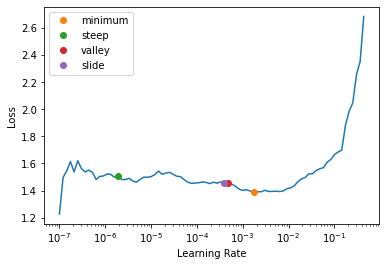

In [60]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

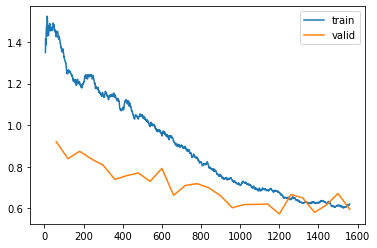

In [61]:
learn.recorder.plot_loss()

0.6359832635983264 0.6139664804469274 0.572661693076022 0.5907821229050279 0.5907821229050279 0.5737295825771325
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6359832635983264	0.6139664804469274	0.572661693076022	0.5907821229050279	0.5907821229050279	0.5737295825771325
              precision    recall  f1-score   support

           0       0.80      0.68      0.74       179
           1       0.34      0.50      0.41        60

    accuracy                           0.64       239
   macro avg       0.57      0.59      0.57       239
weighted avg       0.69      0.64      0.65       239



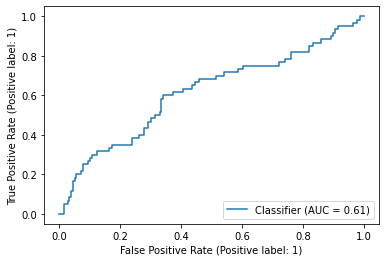

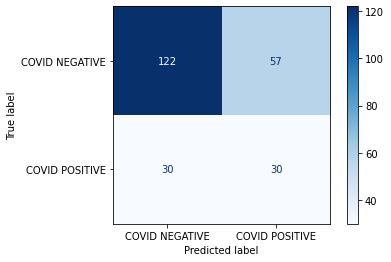

In [62]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-50

Better model found at epoch 0 with accuracy value: 0.49302324652671814.
Better model found at epoch 1 with accuracy value: 0.6465116143226624.
No improvement since epoch 1: early stopping


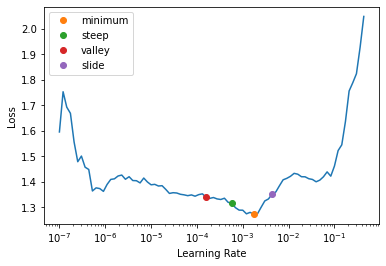

In [63]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

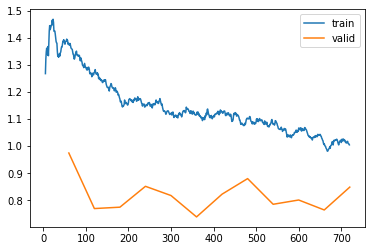

In [64]:
learn.recorder.plot_loss()

0.5146443514644351 0.4869646182495344 0.4705118411000765 0.4931564245810056 0.4931564245810056 0.4948202959830867
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.5146443514644351	0.4869646182495344	0.4705118411000765	0.4931564245810056	0.4931564245810056	0.4948202959830867
              precision    recall  f1-score   support

           0       0.74      0.54      0.62       179
           1       0.25      0.45      0.32        60

    accuracy                           0.51       239
   macro avg       0.49      0.49      0.47       239
weighted avg       0.62      0.51      0.55       239



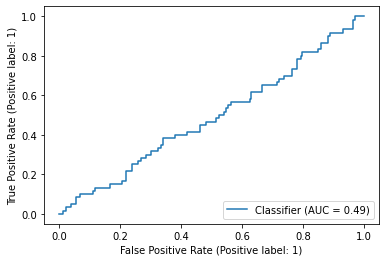

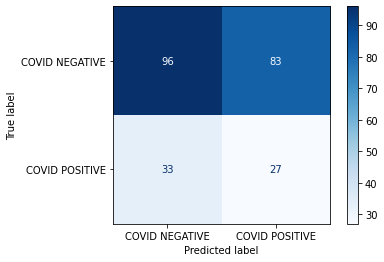

In [65]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### ResNet-101

Better model found at epoch 0 with accuracy value: 0.5627906918525696.
Better model found at epoch 1 with accuracy value: 0.604651153087616.
Better model found at epoch 3 with accuracy value: 0.6093023419380188.
Better model found at epoch 5 with accuracy value: 0.6372092962265015.
Better model found at epoch 8 with accuracy value: 0.6511628031730652.
Better model found at epoch 11 with accuracy value: 0.6837209463119507.
No improvement since epoch 11: early stopping


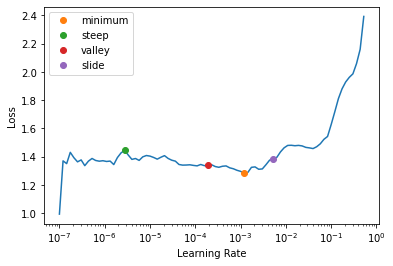

In [66]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

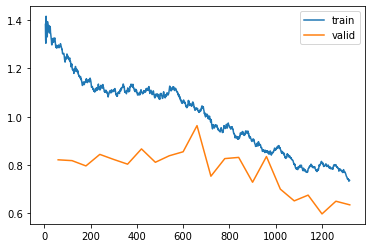

In [67]:
learn.recorder.plot_loss()

0.6276150627615062 0.6155493482309126 0.5751323279736343 0.6018156424581006 0.6018156424581006 0.5799342105263158
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6276150627615062	0.6155493482309126	0.5751323279736343	0.6018156424581006	0.6018156424581006	0.5799342105263158
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       179
           1       0.35      0.55      0.43        60

    accuracy                           0.63       239
   macro avg       0.58      0.60      0.58       239
weighted avg       0.70      0.63      0.65       239



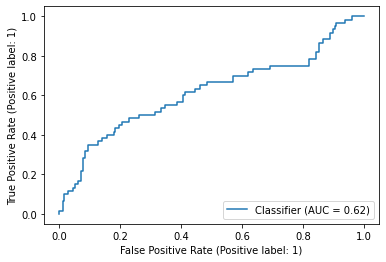

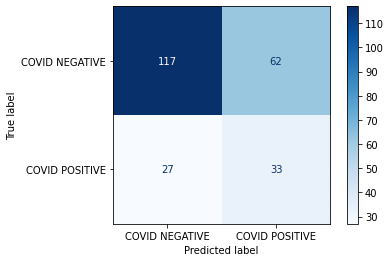

In [68]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg16_bn

Better model found at epoch 0 with accuracy value: 0.47441861033439636.
Better model found at epoch 1 with accuracy value: 0.5441860556602478.
Better model found at epoch 3 with accuracy value: 0.5534883737564087.
Better model found at epoch 5 with accuracy value: 0.5767441987991333.
Better model found at epoch 7 with accuracy value: 0.6465116143226624.
Better model found at epoch 9 with accuracy value: 0.6511628031730652.
Better model found at epoch 14 with accuracy value: 0.6976743936538696.
No improvement since epoch 14: early stopping


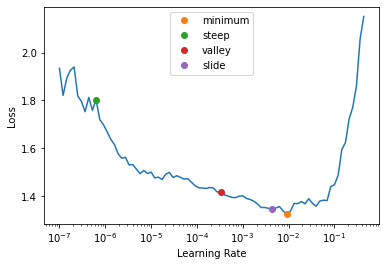

In [69]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

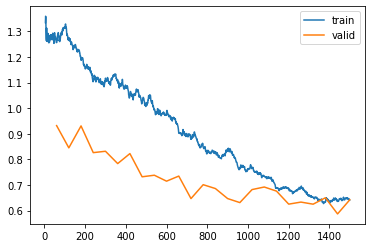

In [70]:
learn.recorder.plot_loss()

0.5899581589958159 0.6068901303538174 0.5451685567811093 0.5766759776536313 0.5766759776536313 0.5586538461538462
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.5899581589958159	0.6068901303538174	0.5451685567811093	0.5766759776536313	0.5766759776536313	0.5586538461538462
              precision    recall  f1-score   support

           0       0.80      0.60      0.69       179
           1       0.32      0.55      0.40        60

    accuracy                           0.59       239
   macro avg       0.56      0.58      0.55       239
weighted avg       0.68      0.59      0.62       239



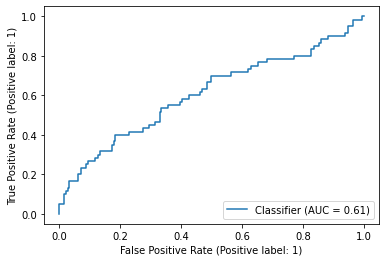

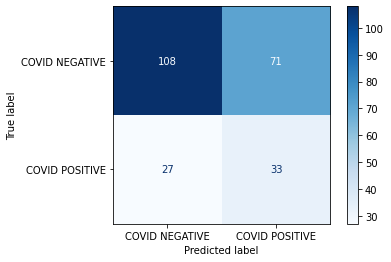

In [71]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### vgg19_bn

Better model found at epoch 0 with accuracy value: 0.6000000238418579.
Better model found at epoch 1 with accuracy value: 0.6279069781303406.
Better model found at epoch 2 with accuracy value: 0.6465116143226624.
Better model found at epoch 3 with accuracy value: 0.6930232644081116.
Better model found at epoch 4 with accuracy value: 0.734883725643158.
No improvement since epoch 4: early stopping


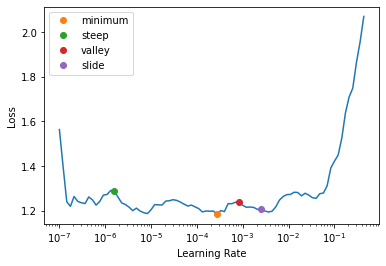

In [72]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

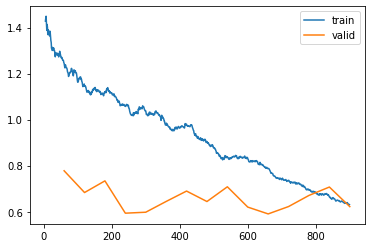

In [73]:
learn.recorder.plot_loss()

0.6276150627615062 0.6384543761638733 0.5722272498743087 0.5962756052141527 0.5962756052141527 0.5761525997937841
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6276150627615062	0.6384543761638733	0.5722272498743087	0.5962756052141527	0.5962756052141527	0.5761525997937841
              precision    recall  f1-score   support

           0       0.81      0.66      0.73       179
           1       0.34      0.53      0.42        60

    accuracy                           0.63       239
   macro avg       0.58      0.60      0.57       239
weighted avg       0.69      0.63      0.65       239



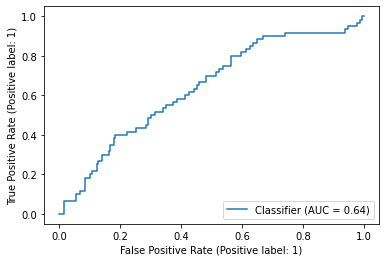

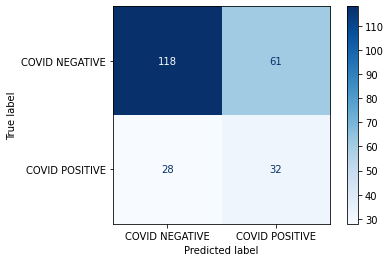

In [74]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### alexnet

Better model found at epoch 0 with accuracy value: 0.6000000238418579.
Better model found at epoch 1 with accuracy value: 0.6186046600341797.
Better model found at epoch 2 with accuracy value: 0.6418604850769043.
Better model found at epoch 7 with accuracy value: 0.6651162505149841.
Better model found at epoch 15 with accuracy value: 0.6744186282157898.
Better model found at epoch 16 with accuracy value: 0.6790697574615479.
Better model found at epoch 18 with accuracy value: 0.7209302186965942.
No improvement since epoch 18: early stopping


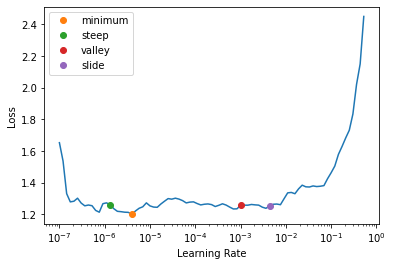

In [75]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

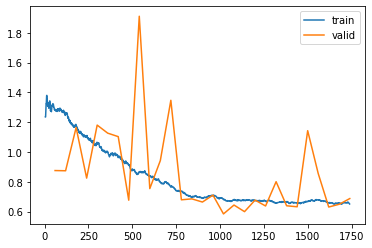

In [76]:
learn.recorder.plot_loss()

0.6610878661087866 0.6351024208566108 0.5891640669765073 0.6020018621973929 0.6020018621973929 0.5866693037974684
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6610878661087866	0.6351024208566108	0.5891640669765073	0.6020018621973929	0.6020018621973929	0.5866693037974684
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       179
           1       0.37      0.48      0.42        60

    accuracy                           0.66       239
   macro avg       0.59      0.60      0.59       239
weighted avg       0.70      0.66      0.67       239



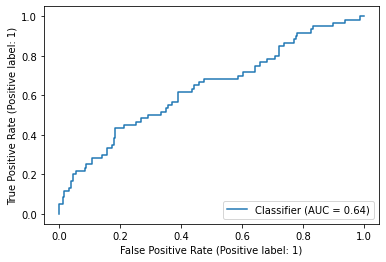

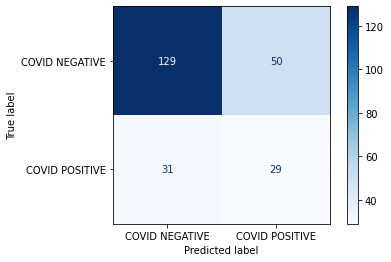

In [77]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### squeezenet1_0

Better model found at epoch 0 with accuracy value: 0.539534866809845.
Better model found at epoch 1 with accuracy value: 0.5534883737564087.
Better model found at epoch 2 with accuracy value: 0.6232557892799377.
Better model found at epoch 3 with accuracy value: 0.6279069781303406.
Better model found at epoch 7 with accuracy value: 0.6465116143226624.
Better model found at epoch 9 with accuracy value: 0.6790697574615479.
Better model found at epoch 11 with accuracy value: 0.6976743936538696.
Better model found at epoch 20 with accuracy value: 0.7488372325897217.
No improvement since epoch 20: early stopping


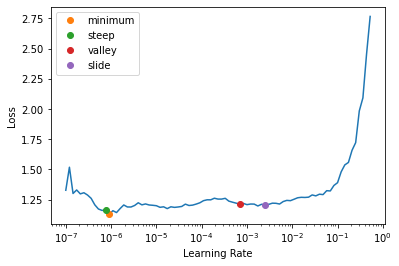

In [78]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

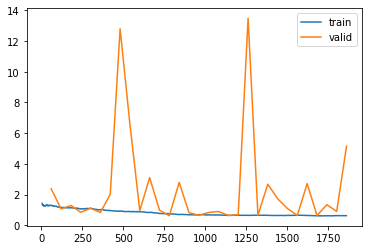

In [79]:
learn.recorder.plot_loss()

0.6736401673640168 0.654562383612663 0.5918286915396742 0.5993016759776536 0.5993016759776536 0.5886976047904191
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6736401673640168	0.654562383612663	0.5918286915396742	0.5993016759776536	0.5993016759776536	0.5886976047904191
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       179
           1       0.38      0.45      0.41        60

    accuracy                           0.67       239
   macro avg       0.59      0.60      0.59       239
weighted avg       0.70      0.67      0.68       239



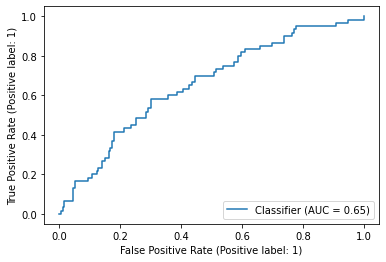

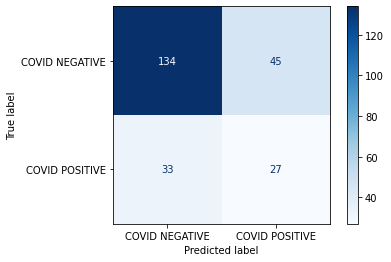

In [80]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### densenet121

Better model found at epoch 0 with accuracy value: 0.5860465168952942.
Better model found at epoch 1 with accuracy value: 0.6186046600341797.
Better model found at epoch 2 with accuracy value: 0.6604651212692261.
Better model found at epoch 5 with accuracy value: 0.7116279006004333.
No improvement since epoch 5: early stopping


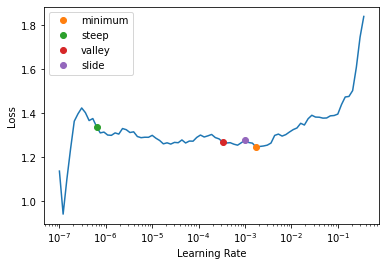

In [81]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

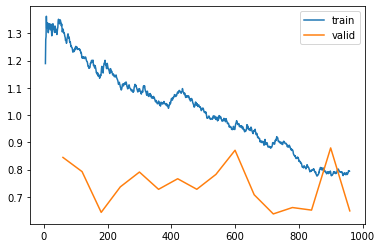

In [82]:
learn.recorder.plot_loss()

0.5690376569037657 0.6003724394785848 0.5233420466647304 0.5516294227188082 0.5516294227188082 0.539410092395167
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.5690376569037657	0.6003724394785848	0.5233420466647304	0.5516294227188082	0.5516294227188082	0.539410092395167
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       179
           1       0.30      0.52      0.38        60

    accuracy                           0.57       239
   macro avg       0.54      0.55      0.52       239
weighted avg       0.66      0.57      0.60       239



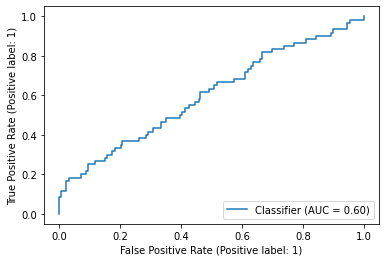

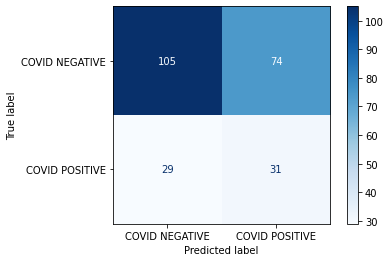

In [83]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()

### xresnet50

Better model found at epoch 0 with accuracy value: 0.5906976461410522.
Better model found at epoch 1 with accuracy value: 0.6139534711837769.
Better model found at epoch 2 with accuracy value: 0.6465116143226624.
Better model found at epoch 3 with accuracy value: 0.6651162505149841.
Better model found at epoch 4 with accuracy value: 0.6976743936538696.
Better model found at epoch 8 with accuracy value: 0.7069767713546753.
Better model found at epoch 11 with accuracy value: 0.7162790894508362.
Better model found at epoch 13 with accuracy value: 0.7581395506858826.
No improvement since epoch 13: early stopping


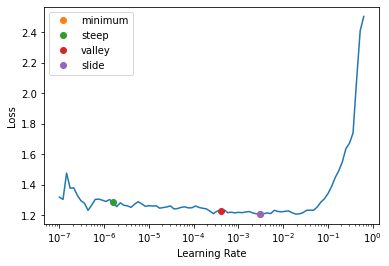

In [84]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here
                    metrics=[accuracy, RocAucBinary(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True), EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Run 
learn.fit_one_cycle(50, lrs.valley)

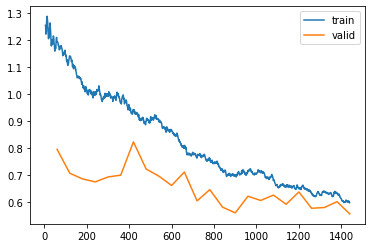

In [85]:
learn.recorder.plot_loss()

0.6903765690376569 0.6788640595903167 0.6230605285592498 0.6381750465549348 0.6381750465549348 0.6181716833890747
^^    accuracy, rocauc, f1, recall, specificity, precision    ^^
0.6903765690376569	0.6788640595903167	0.6230605285592498	0.6381750465549348	0.6381750465549348	0.6181716833890747
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       179
           1       0.41      0.53      0.46        60

    accuracy                           0.69       239
   macro avg       0.62      0.64      0.62       239
weighted avg       0.72      0.69      0.70       239



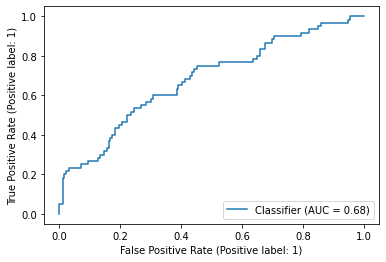

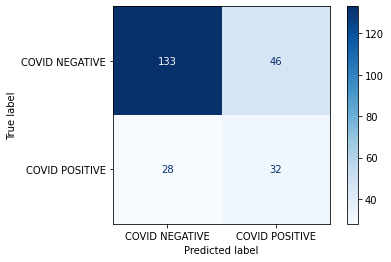

In [86]:
xx = learn.load('./model')

pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)

acc = accuracy_score(actual_classes, pred_classes)
rocauc = roc_auc_score(actual_classes, pred_probas[:, 1], average='macro')
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^    accuracy, rocauc, f1, recall, specificity, precision    ^^')
print(str(acc)+'\t'+str(rocauc)+'\t'+str(fone)+'\t'+ str(rec)+'\t'+str(spc)+'\t'+ str(prec))

print(classification_report(actual_classes, pred_classes))       
RocCurveDisplay.from_predictions(actual_classes, pred_probas[:, 1])
plt.show()

ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab,cmap=plt.cm.Blues)
plt.show()